In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error,mean_squared_log_error,median_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer, KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv('/content/OUTPUT_WBI_exposer_cyclones_v14.csv', sep = ';')

In [0]:
def handle_landing(df):
  df['Landing'] = [0 if x == 'No landing' else 1 for x in df['MAX_USA_SSHS_INLAND']]
  df['MAX_USA_SSHS_INLAND'] = df['MAX_USA_SSHS_INLAND'].replace('No landing', '-7') #New categorie for No landing variable
  return df

def handle_usa_sshs(df):
  df["MAX_USA_SSHS"]= df["MAX_USA_SSHS"].replace(-6, np.nan) 
  df["MAX_USA_SSHS_INLAND"]= df["MAX_USA_SSHS_INLAND"].replace('-6', np.nan)
  df['MAX_USA_SSHS_INLAND'] = df['MAX_USA_SSHS_INLAND'].astype(float)
  return df

def calculate_assets(df):
  df['CALC_assets_emdat'] = df['34KN_ASSETS'] + df['64KN_ASSETS'] + df['96KN_ASSETS']
  return df

def process_income_final(df):
  """
    Process the Income Final Level column into numerical

    Usage
    ------

    df = process_total_damaged(df)
  """
  #Arnab code
  unique_list = df['Income_level_Final'].unique()
  incomelevel_to_int = dict(zip(unique_list, [1,2,4,3])) # so we assign['Low' =1, 'Low_Middle' =2, 'High'=4, 'High_Middle'=3]
  df['Income_level_Final'] = df['Income_level_Final'].apply(lambda inc_level: incomelevel_to_int[inc_level])
  return df
  
def null_cols(data):

    """
    This function takes a dataframe df and shows the columns of df that have NaN values
    and the number of them

    """
    nulls = data.isna().sum()
    nulls = nulls[nulls > 0] / len(data) * 100
    nulls = pd.DataFrame(nulls.sort_values(ascending = False))
    nulls = nulls.reset_index().rename(columns = {"index": "Feature", 0: "% Null rows"})
    return nulls

def drop_columns(df):
  columns_to_drop = ['SID','NAME','YEAR','BASIN','COORDS','COORDS_MAX_WINDS', 'COORDS_MIN_DIST2LAND','DATE_START','DATE_LAND_END','DATE_LAND_START','DATE_END','34KN_ASSETS','64KN_ASSETS','96KN_ASSETS','34KN_POP','64KN_POP','96KN_POP', 'TOTAL_DAMAGE_(000$)','TOTAL_DEATHS']
  df = df.drop(columns_to_drop, axis = 1)
  return df

def create_dummies(df, column_name):
   """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    df = create_dummies(train, categorical_column)
    """
   dummies = pd.get_dummies(df[column_name], prefix=column_name)
   df = pd.concat([df,dummies],axis=1)
   return df

def get_results(predictions, y_test, score):
 
  mse = mean_squared_error(y_test, predictions)
  print(f'Mean Squared Error: {mse:.2f}')
  rmse = np.sqrt(mse)
  print(f'Root Mean Squared Error: {rmse:.2f}')
  mae = mean_absolute_error(y_test, predictions)
  print(f'Mean Absolute Error: {mae:.2f}')
  #Variance score: 1 is perfect prediction score
  explained_variance = explained_variance_score(y_test, predictions)
  print(f'Explained Variance Score: {explained_variance:.3f}')
  msle = mean_squared_log_error(y_test, predictions)
  print(f'Mean Squared Log Error: {msle:.2f}')
  median_ae = median_absolute_error(y_test, predictions)
  print(f'Median Absolute Error: {median_ae:.2f}')
  print(f'R^2 Prediction Score: {score:.4f}')

def data_preprocessing(df):
  df = handle_landing(df)
  df = handle_usa_sshs(df)
  df = process_income_final(df)
  df = drop_columns(df)
  return df




In [0]:
df = data_preprocessing(df)

## Generate Dummies

In [5]:
cat_columns = df.dtypes[df.dtypes == 'object'].index
print(cat_columns)
for categorical in cat_columns:
  df = create_dummies(df,categorical)
  df = df.drop(categorical, axis = 1)

Index(['ISO', 'SUB BASIN', 'NATURE', 'GENERAL_CATEGORY'], dtype='object')


In [6]:
null_df = null_cols(df)
null_columns = null_df['Feature']
null_columns

0                                        POP_MAX_64_ADJ
1                                        POP_MAX_50_ADJ
2                                        POP_MAX_34_ADJ
3     Adjusted savings: education expenditure (% of ...
4                         Cereal yield (kg per hectare)
5                    GDP per capita (constant 2010 US$)
6               Life expectancy at birth, total (years)
7               Food production index (2004-2006 = 100)
8                                        MAX_STORMSPEED
9                     Arable land (hectares per person)
10                                  MAX_USA_SSHS_INLAND
11                                         MAX_USA_SSHS
Name: Feature, dtype: object

In [0]:
#imputer = SimpleImputer(missing_values= np.nan, strategy='mean')
#for cols in null_columns:
 #   df[cols] = imputer.fit_transform(df[[cols]])

In [0]:
imputer = KNNImputer(missing_values=np.nan, n_neighbors= 3)
for cols in null_columns:
    df[cols] = imputer.fit_transform(df[[cols]])

## Model

In [0]:
X = df.drop('TOTAL_AFFECTED', axis = 1)
y = df['TOTAL_AFFECTED']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)


In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [13]:
X_train.shape, X_test.shape

((693, 115), (298, 115))

In [14]:
y_train.shape, y_test.shape

((693,), (298,))

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [0]:
model = Sequential()

model.add(Dense(115,activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(64,activation='relu'))
#model.add(Dropout(0.20))
model.add(Dense(18,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',  metrics=['mean_absolute_error'])

In [38]:
model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=128,epochs=1000, callbacks=[early_stop])

Epoch 1/1000
6/6 [==============================] - 0s 20ms/step - loss: 4341164146688.0000 - mean_absolute_error: 590311.1875 - val_loss: 4373541814272.0000 - val_mean_absolute_error: 561399.9375
Epoch 2/1000
6/6 [==============================] - 0s 7ms/step - loss: 4341163360256.0000 - mean_absolute_error: 590310.6875 - val_loss: 4373541289984.0000 - val_mean_absolute_error: 561399.5000
Epoch 3/1000
6/6 [==============================] - 0s 7ms/step - loss: 4341162311680.0000 - mean_absolute_error: 590310.1250 - val_loss: 4373541027840.0000 - val_mean_absolute_error: 561398.8125
Epoch 4/1000
6/6 [==============================] - 0s 8ms/step - loss: 4341161525248.0000 - mean_absolute_error: 590309.3750 - val_loss: 4373539192832.0000 - val_mean_absolute_error: 561397.6250
Epoch 5/1000
6/6 [==============================] - 0s 7ms/step - loss: 4341159952384.0000 - mean_absolute_error: 590308.0000 - val_loss: 4373536833536.0000 - val_mean_absolute_error: 561395.6250
Epoch 6/1000
6/6 [=

In [0]:
losses = pd.DataFrame(model.history.history)

In [40]:
losses

,loss,mean_absolute_error,val_loss,val_mean_absolute_error
0,4.341164e+12,590311.1875,4.373542e+12,561399.9375
1,4.341163e+12,590310.6875,4.373541e+12,561399.5000
2,4.341162e+12,590310.1250,4.373541e+12,561398.8125
3,4.341162e+12,590309.3750,4.373539e+12,561397.6250
4,4.341160e+12,590308.0000,4.373537e+12,561395.6250
...,...,...,...,...
499,3.234018e+12,729020.7500,3.545115e+12,698100.1250
500,3.248711e+12,725338.4375,3.544986e+12,697392.0625
501,3.235138e+12,724168.0625,3.544627e+12,695763.1875
502,3.235909e+12,722019.3125,3.544681e+12,695492.0000


In [0]:
predictions = model.predict(X_test)

In [42]:
get_results(predictions, y_test, 0)
#R^2 is 0 because we dont have score for pass into the get_results function


Mean Squared Error: 3544511638971.18
Root Mean Squared Error: 1882687.34
Mean Absolute Error: 694337.96
Explained Variance Score: 0.127
Mean Squared Log Error: 10.98
Median Absolute Error: 145074.41
R^2 Prediction Score: 0.0000


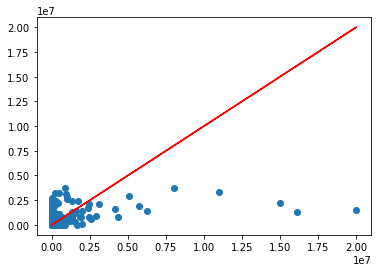

In [43]:
# Our predictions
plt.scatter(y_test,predictions)

# Perfect predictions
plt.plot(y_test,y_test,'r')

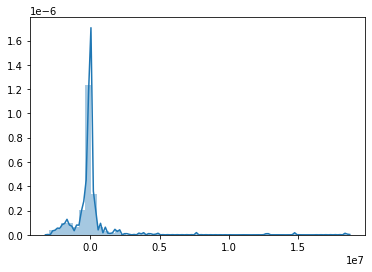

In [24]:
errors = y_test.values.reshape(298, 1) - predictions
sns.distplot(errors)